# Regresion con redes neuronales en sklearn




## Configuracion y cargue de datos

Cargamos las librerias que utilizaremos 


In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from sklearn import datasets
from sklearn.datasets import make_moons
import pandas as pd
import pylab as pl
import numpy as np


# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Leemos el directorio del Drive para la lectura de los datos

In [ ]:
file_list = drive.ListFile({'q': "'1WmHD_zkb3kbUxniy2areJhOvJmY16o3_' in parents and trashed=false"}).GetList()
for file1 in file_list:
  print('title: %s, id: %s' % (file1['title'], file1['id']))

title: Series de tiempo con TensorFlow.ipynb, id: 1aVcqR4e_Stq5DrypoPd4-W_Uqrj8kWFy
title: Redes Neuronales Recurrentes, id: 1f0GR_pipvw_d0PsOJqTA_9ilgQXCWE55VRu-en3ygCw
title: readme.txt, id: 1SXQPVM-Gb2rz7HmEOkQs8vFmQthwGl2A
title: london_merged.csv, id: 1G-BcnSTpxFSSOF_zhknRDwN4aeVEMCQr
title: yahoo_stock.csv, id: 1fDlIrPO8ScORLw_FvKOb8RfUEFi-l8jh
title: GME_stock.csv, id: 1t-CArugHTFchz4nxsmf7U4GfJQKY6DF3


In [ ]:
train_downloaded = drive.CreateFile({'id': '1G-BcnSTpxFSSOF_zhknRDwN4aeVEMCQr'})
train_downloaded.GetContentFile('london_merged.csv')
#train_downloaded = drive.CreateFile({'id': '1gKsMQwGEvQMK89hhRSpDG'})
datos=pd.read_csv('london_merged.csv')

## Analisis y tratamaiento de datos

Leemos los datos y segregamos la variable de tiempo 

In [ ]:
datos["timestamp"] = pd.to_datetime(datos["timestamp"])
datos = datos.set_index("timestamp")
datos["hour"] = datos.index.hour
datos["day_of_month"] = datos.index.day
datos["day_of_week"]  = datos.index.dayofweek
datos["month"] = datos.index.month
datos.head()
datos.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,hour,day_of_month,day_of_week,month
timestamp,,,,,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0,0,4,6,1
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0,1,4,6,1
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0,2,4,6,1
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0,3,4,6,1
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0,4,4,6,1


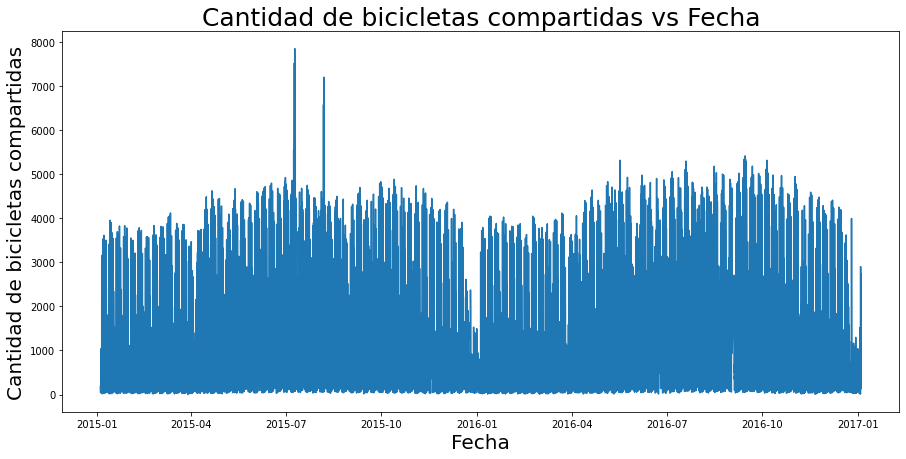

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.figure(figsize=(15, 7))
ax = sns.lineplot(x=datos.index, y=datos.cnt,data=datos)
ax.set_title("Cantidad de bicicletas compartidas vs Fecha", fontsize=25)
ax.set_xlabel("Fecha", fontsize=20)
ax.set_ylabel('Cantidad de bicicletas compartidas', fontsize=20)
plt.show()

El analisis por fecha sin tratamiento genera unas variaciones demasiado grandes por lo que analizaremos los datos por mes

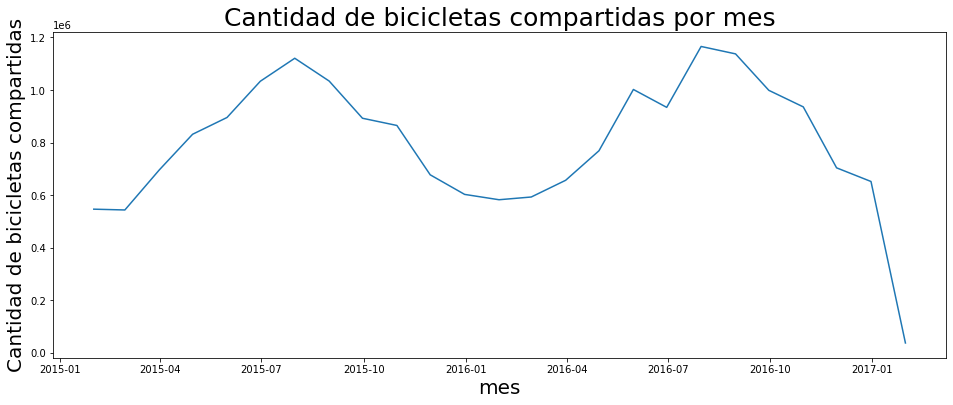

In [ ]:
# Resample timeseries, for plotting timeseries month frequency
df_by_month = datos.resample("M").sum()
plt.figure(figsize=(16,6))
ax = sns.lineplot(data=df_by_month,x=df_by_month.index,y=df_by_month.cnt)
ax.set_title("Cantidad de bicicletas compartidas por mes", fontsize=25)
ax.set_xlabel("mes", fontsize=20)
ax.set_ylabel('Cantidad de bicicletas compartidas', fontsize=20)
plt.show()

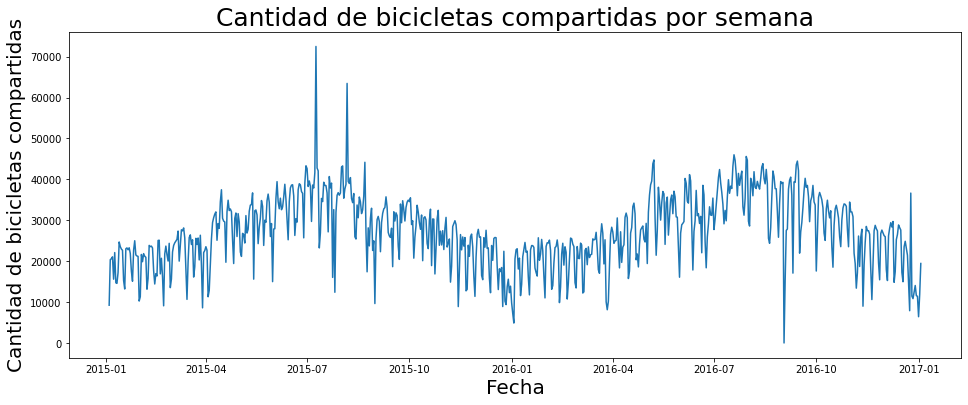

In [ ]:
df_by_week = datos.resample("D").sum()
plt.figure(figsize=(16,6))
ax = sns.lineplot(data=df_by_week,x=df_by_week.index,y=df_by_week.cnt)
ax.set_title("Cantidad de bicicletas compartidas por semana", fontsize=25)
ax.set_xlabel("Fecha", fontsize=20)
ax.set_ylabel('Cantidad de bicicletas compartidas', fontsize=20)
plt.show()

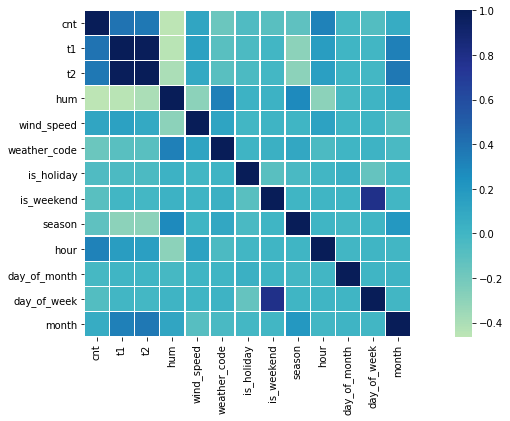

In [ ]:
plt.figure(figsize=(16,6))
sns.heatmap(datos.corr(),cmap="YlGnBu",square=True,linewidths=.5,center=0)

In [ ]:
data2=df_by_week.reset_index()
data2['conteo']=data2.index
data2.head(2)

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,hour,day_of_month,day_of_week,month,conteo
0,2015-01-04,9234,59.5,15.5,2262.5,180.0,69.0,0.0,24.0,72.0,276,96,144,24,0
1,2015-01-05,20372,193.0,161.0,1927.5,212.5,80.0,0.0,0.0,72.0,276,120,0,24,1


In [ ]:
y=data2['cnt']
X=data2[['conteo']]
#X=data2.drop(columns=['cnt','fecha_semanal','timestamp'])

In [ ]:
X = X.to_numpy()
type(X)
y = y.to_numpy()
type(y)

numpy.ndarray

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Modelo de regresion Lineal 

Usamos sklearn.linear_model.LinearRegression para ajustar nuestro modelo a los datos de entrenamiento. Como se ha visto, el API de Scikit-Learn es muy consistente.

In [ ]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

A continuación, podemos extraer también el valor de la pendiente y de la intersección con el eje $y$.

In [ ]:
print('Pendiente: {}'.format(regressor.coef_[0]))
print('Intersección en y: {}'.format(regressor.intercept_))

Pendiente: 4.605730955158272
Intersección en y: 25855.19339699508


Visualizamos los datos de entrenamiento contra la línea generada por la ecuación:
y=wx+w0

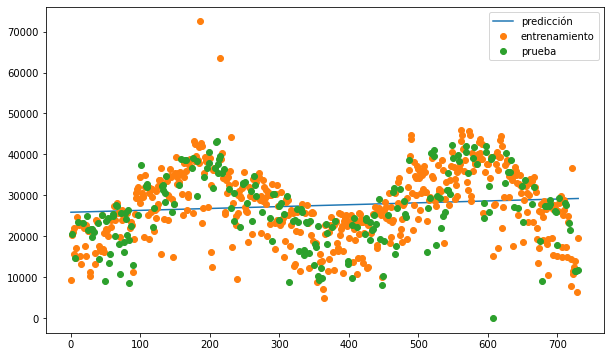

In [ ]:
min_pt = X.min() * regressor.coef_[0] + regressor.intercept_
max_pt = X.max()  * regressor.coef_[0] + regressor.intercept_

pl.figure(figsize = (10, 6))
pl.plot([X.min(), X.max()], [min_pt, max_pt], label="predicción")
pl.plot(X_train, y_train, 'o', label="entrenamiento");
pl.plot(X_test, y_test, 'o', label="prueba");
pl.legend(loc='best');

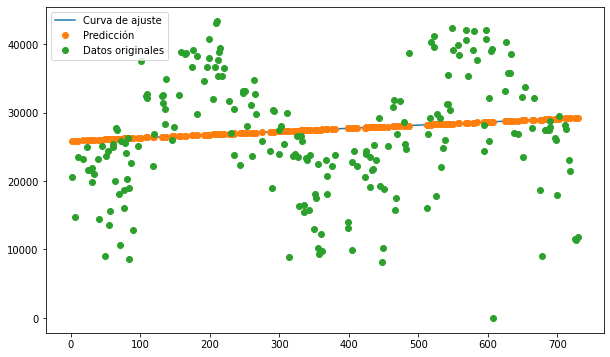

In [ ]:
y_pred = regressor.predict(X_test)
pl.figure(figsize = (10, 6))
pl.plot([X.min(), X.max()], [min_pt, max_pt], label="Curva de ajuste")
pl.plot(X_test, y_pred, 'o', label="Predicción");
pl.plot(X_test, y_test, 'o', label="Datos originales");
pl.legend(loc='best');

Medimos el error cuadrático medio:

In [ ]:
from sklearn.metrics import mean_squared_error

pred = regressor.predict(X_test)
mean_squared_error(pred, y_test)

74396726.86339384

## MLPRegressor


De la misma forma, podemos entrenar una red multicapa para resolver el problema de regresión. Scikit-Learn provee una implementación a través de `sklearn.neural_network.MLPRegressor`. La red multicapa generada por Scikit-Learn difiere de la implementación usada para clasificación, en que esta no tiene función de activación en la capa de salida. Aquí estamos interesados en predecier el valor original de una variable numérica, no necesitamos acotarlo a un rango definido como en el problema de clasificación. La medida por defecto que se usa para determinar el desempeño del modelo es error cuadrático medio (**MSE**).

### Función de activación ReLU

A continuación, introducimos una nueva función de activación conocida como *ReLU*. Las redes multicapa con funciones de activación logística tienen un problema durante el entrenamiento, conocido como el **desvanecimiento del gradiente**. Esto consiste en que la magnitud del gradiente se va haciendo muy pequeña de tal forma que los pesos de varias conexiones de la red multicapa no se actualizan. Esto resulta en que el modelo no resuelve el problema supervisado. La función de activación $\textit{ReLU}$ se usa con el objetivo de resolver ese problema. $\textit{ReLU}$ está definida como:

$$
\textit{ReLU}(x) = \max(0, x)
$$

<img src="https://drive.google.com/uc?export=view&id=1nT30AjTNGiGVayCm07YNE5FsHG73JK9L" align="middle">

In [ ]:
from sklearn.neural_network import MLPRegressor

Aquí observamos la arquitectura de la red multicapa del modelo más complejo:

---



<img src="https://drive.google.com/uc?export=view&id=1rUJOF7Spn0X1vakcQia6fMYT90nKekrp" align="middle">

Escale los datos para que tengan media cero varianza uno por característica 

In [ ]:
from sklearn.preprocessing import StandardScaler
 
sc_x = StandardScaler()
sc_x.fit(X)
X_train = sc_x.transform(X_train)
X_test = sc_x.transform(X_test)

###Parámetros 
solver{‘lbfgs’, ‘sgd’, ‘adam’}, default=’adam’
* 'lbfgs' es un optimizador de la familia de métodos cuasi-Newton.
* 'sgd' se refiere al descenso de gradiente estocástico.
* 'adam' se refiere a un optimizador estocástico basado en gradientes propuesto por Kingma, Diederik y Jimmy Ba

alpha float, predeterminado = 0.0001 
* Parámetro de penalización L2 (término de regularización).

activation{‘identity’, ‘logistic’, ‘tanh’, ‘relu’}, default=’relu’
* ‘identity’: activación sin operación, útil para implementar un cuello de botella lineal, devuelve f (x) = x
* ‘logistic’:  la función sigmoidea logística, devuelve f (x) = 1 / (1 + exp (-x)).
* ‘tanh’: la función tan hiperbólica, devuelve f (x) = tanh (x).
* ‘relu’: la función de unidad lineal rectificada, devuelve f (x) = max (0, x)

hidden_layer_sizestuple, length = n_layers - 2, default=(100,)
* representa el número de neuronas en la i-ésima capa oculta

random_stateint, RandomState instance, default=None
* Determina la generación de números aleatorios para las ponderaciones y la inicialización de sesgo, la división de prueba de tren si se usa la parada temprana y el muestreo por lotes cuando solver = 'sgd' o 'adam'. Pase un int para obtener resultados reproducibles en varias llamadas a funciones. Consulte el glosario .

In [ ]:
mlp_regressor_simple = MLPRegressor(solver='lbfgs', alpha=1e-5, activation='relu',
                                       hidden_layer_sizes=(5,10,5), random_state=1)

mlp_regressor_complex = MLPRegressor(solver='lbfgs', alpha=1e-5, activation='relu',
                                       hidden_layer_sizes=(128,520,128), random_state=1)

mlp_regressor_complex2 = MLPRegressor(solver='lbfgs', alpha=1e-5, activation='relu',
                                       hidden_layer_sizes=(5,10,20,30,35), random_state=1)


In [ ]:
mlp_regressor_simple.fit(X_train, y_train)
mlp_regressor_complex.fit(X_train, y_train);
mlp_regressor_complex2.fit(X_train, y_train);

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

In [ ]:
idx = np.argsort(X_train.flatten())
X_train_s = X_train[idx]
y_train_s = y_train[idx]
idx = np.argsort(X_test.flatten())
X_test_s = X_test[idx]
y_test_s = y_test[idx]

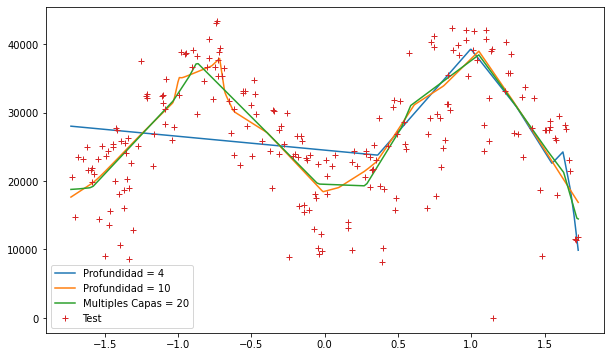

In [ ]:
y_pred_4 = mlp_regressor_simple.predict(X_train_s)
y_pred_10 = mlp_regressor_complex.predict(X_train_s)
y_pred_capas = mlp_regressor_complex2.predict(X_train_s)

pl.figure(figsize = (10, 6))
pl.plot(X_train_s, y_pred_4, label="Profundidad = 4");
pl.plot(X_train_s, y_pred_10, label="Profundidad = 10");
pl.plot(X_train_s, y_pred_capas, label="Multiples Capas = 20");
pl.plot(X_test_s, y_test_s, '+', label="Test");
pl.legend(loc='best');

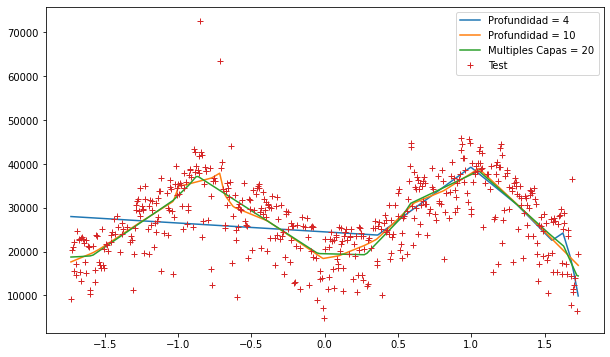

In [ ]:
y_pred_4 = mlp_regressor_simple.predict(X_train_s)
y_pred_10 = mlp_regressor_complex.predict(X_train_s)
y_pred_capas = mlp_regressor_complex2.predict(X_train_s)

pl.figure(figsize = (10, 6))
pl.plot(X_train_s, y_pred_4, label="Profundidad = 4");
pl.plot(X_train_s, y_pred_10, label="Profundidad = 10");
pl.plot(X_train_s, y_pred_capas, label="Multiples Capas = 20");
pl.plot(X_train, y_train, '+', label="Test");
pl.legend(loc='best');

In [ ]:
mlp_regressor_tagente = MLPRegressor(solver='lbfgs', alpha=1e-5, activation='tanh',
                                       hidden_layer_sizes=(128,520,128), random_state=1)
mlp_regressor_tagente.fit(X_train, y_train)

MLPRegressor(activation='tanh', alpha=1e-05, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(128, 520, 128), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=200,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=1, shuffle=True, solver='lbfgs',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)

<img src='https://upload.wikimedia.org/wikipedia/commons/6/64/RedNeuronalArtificial.png'>

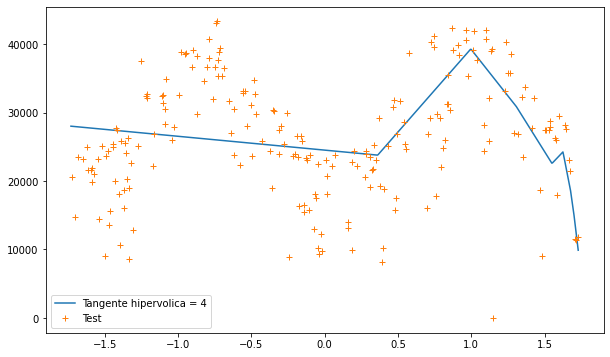

In [ ]:
y_pred_capas = mlp_regressor_tagente.predict(X_train_s)

pl.figure(figsize = (10, 6))
pl.plot(X_train_s, y_pred_4, label="Tangente hipervolica = 4");
pl.plot(X_test_s, y_test_s, '+', label="Test");
pl.legend(loc='best');

In [ ]:
pred = regressor.predict(X_test)
mean_squared_error(pred, y_test)

print('MSE Regresión Lineal: {}'.format(mean_squared_error(regressor.predict(X_test), y_test)))
print('MSE MLP una capa: {}'.format(mean_squared_error(mlp_regressor_simple.predict(X_test), y_test)))
print('MSE MLP dos capas: {}'.format(mean_squared_error(mlp_regressor_complex.predict(X_test), y_test)))

print('MSE MLP multiples capas: {}'.format(mean_squared_error(mlp_regressor_complex2.predict(X_test), y_test)))

MSE Regresión Lineal: 74431005.93523368
MSE MLP una capa: 61168972.84499739
MSE MLP dos capas: 37305243.52891354
MSE MLP multiples capas: 37920216.7814475


## LSTM Long Short Term Memory

Las redes LSTM es capaz de recordar un dato relevante en la secuencia y de preservarlo a lo largo de la secuencia por lo cual tiene una memoria a corto y a largo plazo.

Estan en capacidad de añadir o eliminar informacion que el considere relevante para generar la salida.

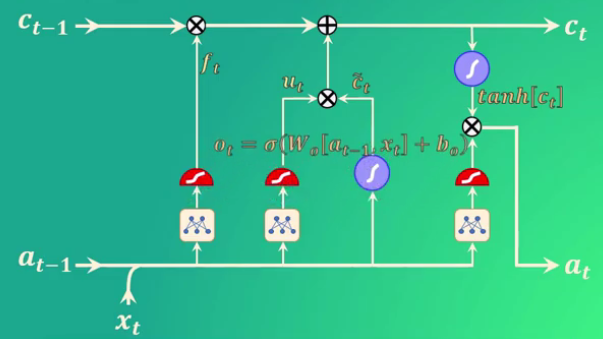

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

In [ ]:
X_train2 = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [ ]:
# The LSTM architecture
regressor_LST = Sequential()
# First LSTM layer with Dropout regularisation
regressor_LST.add(LSTM(units=50, return_sequences=True, activation='relu'))
regressor_LST.add(Dropout(0.2))
# Second LSTM layer
regressor_LST.add(LSTM(units=50, return_sequences=True, activation='relu'))
regressor_LST.add(Dropout(0.2))
# Third LSTM layer
regressor_LST.add(LSTM(units=50, return_sequences=True, activation='relu'))
regressor_LST.add(Dropout(0.2))
# Fourth LSTM layer
regressor_LST.add(LSTM(units=50))
regressor_LST.add(Dropout(0.2))
# The output layer
regressor_LST.add(Dense(units=1))

# Compiling the RNN
regressor_LST.compile(loss="mean_squared_error", optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=True))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
regressor_LST.fit(X_train2,y_train,epochs=550,batch_size=320)

Epoch 1/550
2/2 [==============================] - 39s 14ms/step - loss: 825333866.6667
Epoch 2/550
2/2 [==============================] - 0s 15ms/step - loss: 310113440.0000
Epoch 3/550
2/2 [==============================] - 0s 13ms/step - loss: 165034522.6667
Epoch 4/550
2/2 [==============================] - 0s 13ms/step - loss: 179308869.3333
Epoch 5/550
2/2 [==============================] - 0s 13ms/step - loss: 163247669.3333
Epoch 6/550
2/2 [==============================] - 0s 13ms/step - loss: 128717976.0000
Epoch 7/550
2/2 [==============================] - 0s 13ms/step - loss: 110939112.0000
Epoch 8/550
2/2 [==============================] - 0s 14ms/step - loss: 109535504.0000
Epoch 9/550
2/2 [==============================] - 0s 13ms/step - loss: 102568437.3333
Epoch 10/550
2/2 [==============================] - 0s 13ms/step - loss: 97708770.6667
Epoch 11/550
2/2 [==============================] - 0s 13ms/step - loss: 103814261.3333
Epoch 12/550
2/2 [=======================

In [ ]:
X_test2 = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
pred = regressor_LST.predict(X_test2)
mean_squared_error(pred, y_test)

73008423.87772526

In [ ]:
prediccion=np.array([])
type(pred)
for a in pred:
    #print(a[0])
    prediccion=np.append(prediccion,a[0])

In [ ]:
prediccion

array([29790.125     , 26889.35351562, 25832.57226562, 29692.39648438,
       29790.125     , 31162.5546875 , 26889.35351562, 25832.57226562,
       31162.5546875 , 31658.4140625 , 29790.125     , 25832.57226562,
       25832.57226562, 29790.125     , 26889.35351562, 26889.35351562,
       26889.35351562, 29790.125     , 25832.57226562, 25832.57226562,
       30578.63476562, 31162.5546875 , 29692.39648438, 26889.35351562,
       26889.35351562, 25832.57226562, 26889.35351562, 29790.125     ,
       25832.57226562, 29790.125     , 25832.57226562, 25832.57226562,
       29751.61328125, 31782.42773438, 29692.39648438, 29751.61328125,
       30578.63476562, 30578.63476562, 25832.57226562, 26889.35351562,
       25832.57226562, 26020.38476562, 31162.5546875 , 25832.57226562,
       31162.5546875 , 25832.57226562, 25832.57226562, 26020.38476562,
       29751.61328125, 29751.61328125, 25832.57226562, 25832.57226562,
       25832.57226562, 25832.57226562, 25832.57226562, 25832.57226562,
      

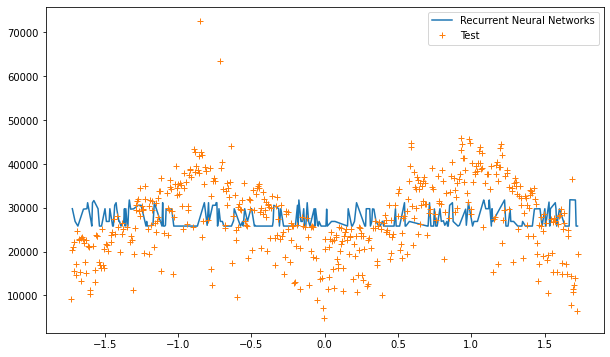

In [ ]:
y_pred_10 = mlp_regressor_complex.predict(X_train_s)

pl.figure(figsize = (10, 6))
pl.plot(X_test_s, prediccion, label="Recurrent Neural Networks");
#pl.plot(X_test_s, y_pred_10, label="Profundidad = 10");
pl.plot(X_train, y_train, '+', label="Test");
pl.legend(loc='best');